<link rel="stylesheet" href="/site-assets/css/gemma.css">
<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Google+Symbols:opsz,wght,FILL,GRAD@20..48,100..700,0..1,-50..200" />

Copyright 2024 Google LLC.

In [ ]:
@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Inference with Keras


## What's in this notebook

This notebook uses PaliGemma with Keras and shows you how to:

* Install Keras and the required dependencies
* Download `PaliGemmaCausalLM`, a pre-trained PaliGemma variant for causal visual language modeling, and use it to create a model
* Test the model's ability to infer information about supplied images

## Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with Keras, but basic knowledge about Keras is helpful when reading through the example code.

## Setup

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access, getting an API key, and configuring the notebook runtime.

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [PaliGemma model card](https://www.kaggle.com/models/google/paligemma/) and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

### Configure your API key

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME`, `KAGGLE_KEY`, and `KERAS_BACKEND`.

In [7]:
import os
import torch
from dotenv import load_dotenv
from roboflow import Roboflow

load_dotenv()

os.environ["ROBOFLOW_API_KEY"] = os.getenv("ROBOFLOW_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"
# Use CUDA and allocate the desired GPU's 
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print(f"Using GPU: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")



Using GPU: 0 - NVIDIA RTX 6000 Ada Generation


### Install Keras

Run the below cell to install Keras.

### Import dependencies and configure Keras

Install the dependencies needed for this notebook and configure Keras' backend. You'll also set Keras to use `bfloat16` so that the framework uses less memory.

In [ ]:
import keras
import keras_nlp
import numpy as np
import PIL
import requests
import io
import matplotlib
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from roboflow import Roboflow
keras.config.set_floatx("bfloat16")

2024-12-19 18:40:01.817125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734630001.844613    2937 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734630001.853117    2937 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/gopi/yes/envs/gemma/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create your model

Now that you've set everything up, you can download the pre-trained model and create some utility methods to help your model generate its responses.

### Download the model checkpoint

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/). In this notebook, you'll create a model using `PaliGemmaCausalLM`, an end-to-end PaliGemma model for *causal visual language modeling*. A causal visual language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method and print its summary. This process will take about a minute to complete.

In [11]:
paligemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("kaggle://keras/paligemma2/keras/pali_gemma2_pt_3b_448")
paligemma.summary()

2024-12-19 18:59:15.090354: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1734631155.090970    2937 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1302 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:04:00.0, compute capability: 8.9
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (448, 448) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 448, 448, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,032,979,696 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,032,979,696 (5.65 GB)

 Trainable params: 3,032,979,696 (5.65 GB)

 Non-trainable params: 0 (0.00 B)

### Utility Methods for Image Processing

**`read_image(file_path, target_size):`** Reads and resizes an image to the target dimensions.  

**`parse_bbox_and_labels(detokenized_output):`** Extracts bounding boxes and labels from a detokenized output.  

**`display_boxes(image, boxes, labels, target_size):`** Draws bounding boxes and labels on an image and displays it.  

**`load_annotations(annotation_file, image_dir):`** Loads image paths and annotations from the JSONL file.  

### Next Steps
These utility methods will support your workflow, including the generation and visualization of image annotations. Use the `read_img_from_url` method in the upcoming sections of this notebook for working with images provided via URLs.


In [12]:
def read_image(file_path, target_size):
    # Read and resize the image to the target size
    image = cv2.imread(file_path)
    image = cv2.resize(image, target_size)
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image

def parse_bbox_and_labels(detokenized_output: str):
    box_strings = detokenized_output.split(" ; ")
    
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0  # Normalize to 1024x1024 size
    
    for box_str in box_strings:
        # Match each bounding box and associated label using regex
        matches = re.finditer(
            r'<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)> (?P<label>.+?)$',
            box_str,
        )
        
        for m in matches:
            d = m.groupdict()
            boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
            labels.append(d['label'])
    
    return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels, target_size):
    image = cv2.resize(image, target_size)
    
    for box, label in zip(boxes, labels):
        y0, x0, y1, x1 = box
        cv2.rectangle(image, (int(x0 * target_size[1]), int(y0 * target_size[0])),
                      (int(x1 * target_size[1]), int(y1 * target_size[0])), (0, 255, 0), 2)
        cv2.putText(image, label, (int(x0 * target_size[1]), int(y0 * target_size[0]) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


def load_annotations(annotation_file, image_dir):
    annotation_data = []
    with open(annotation_file, 'r') as file:
        for line in file:
            data = eval(line.strip())
            image_path = f"{image_dir}/{data['image']}"
            suffix = data['suffix']
            annotation_data.append((image_path, suffix))
    return annotation_data




### Model Evaluation Metrics

**`calculate_iou:`**  
- Computes the Intersection over Union (IoU), which measures the overlap between ground truth and predicted bounding boxes.  
- A higher IoU indicates better localization of the predicted box relative to the ground truth.  

**`evaluate_model:`**  
This method uses the following metrics to assess model performance:  

- **IoU (Intersection over Union):** Average IoU across all evaluated predictions, indicating the accuracy of box localization.  

- **Precision:** The fraction of predicted boxes that are true positives (correct detections). High precision means fewer false positives.  

- **Recall:** The fraction of ground truth boxes that are correctly detected. High recall means fewer false negatives.  

- **F1-Score:** Harmonic mean of precision and recall, balancing their trade-off. A perfect F1-score is 1.  

- **Label Accuracy:** Measures the correctness of predicted class labels with ground truth label for matched boxes.  

**Settings:**  
- An IoU threshold of `0.5` is used to consider a predicted box as a match with a ground truth box.  
- Metrics such as precision, recall, and F1-score are influenced by the threshold and the model's ability to balance localization and classification.  

These metrics provide a comprehensive evaluation of both the spatial accuracy and classification performance for our model.  


In [30]:
def calculate_iou(gt_box, pred_box):
    y0, x0, y1, x1 = gt_box
    py0, px0, py1, px1 = pred_box
    ix0 = max(x0, px0)
    iy0 = max(y0, py0)
    ix1 = min(x1, px1)
    iy1 = min(y1, py1)
    intersection_area = max(0, ix1 - ix0) * max(0, iy1 - iy0)
    gt_area = (x1 - x0) * (y1 - y0)
    pred_area = (px1 - px0) * (py1 - py0)
    union_area = gt_area + pred_area - intersection_area
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

def evaluate_model(results, iou_threshold=0.5):
    total_gt = 0
    total_pred = 0
    true_positives = 0
    iou_scores = []
    label_matches = []

    for res in results:
        gt_boxes, gt_labels = res["gt_boxes"], res["gt_labels"]
        pred_boxes, pred_labels = res["pred_boxes"], res["pred_labels"]
        
        total_gt += len(gt_boxes)
        total_pred += len(pred_boxes)
        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            best_iou = 0
            best_label_match = False
            for pred_box, pred_label in zip(pred_boxes, pred_labels):
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_label_match = (gt_label == pred_label)
            if best_iou >= iou_threshold:
                true_positives += 1
                label_matches.append(best_label_match)
            
            iou_scores.append(best_iou)
    precision = true_positives / total_pred if total_pred else 0
    recall = true_positives / total_gt if total_gt else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
    label_accuracy = sum(label_matches) / len(label_matches) if label_matches else 0

    return {
        "IoU": np.mean(iou_scores) if iou_scores else 0,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Label Accuracy": label_accuracy,
    }



### Model Pipeline: Predictions and Evaluation

The `make_predictions` function processes images in batches, generating predictions based on the input images and prompts. It automatically handles the batching process, yielding predictions for each image along with its corresponding ground truth label. This method helps optimize the prediction process, especially when dealing with large datasets.

The `run_pipeline` function executes the entire prediction and evaluation process. It starts by loading the annotations and generating predictions for the specified number of files (up to `file_limit`). For each image, the ground truth and predicted bounding boxes are parsed, and the Intersection over Union (IoU) scores are calculated to assess how well the predicted boxes match the ground truth. The results are stored in a list, and for the first `display_limit` images, it displays both the ground truth and predicted bounding boxes along with the IoU scores, using matplotlib for visualization. The function returns a collection of results containing the images, bounding boxes, labels, and IoU scores for further analysis.
This pipeline provides an automated way to evaluate the model's performance on new data, offering both quantitative metrics (IoU scores) and qualitative visual feedback through side-by-side comparison of ground truth and predicted bounding boxes. 




In [42]:
def make_predictions(annotation_data, target_size, Prompt, batch_size=None):
    all_images, all_prompts, ground_truth_labels = [], [], []
    prompt = Prompt
    
    for file_path, suffix in annotation_data:
        image = read_image(file_path, target_size)
        all_images.append(image)
        ground_truth_labels.append(suffix)
        all_prompts.append(prompt)
        if len(all_images) == batch_size:
            outputs = paligemma.generate(
                inputs={
                    "images": all_images,
                    "prompts": all_prompts,
                }
            )
            for i, output in enumerate(outputs):
                yield all_images[i], ground_truth_labels[i], output
            all_images, all_prompts = [], []

    if all_images:
        outputs = paligemma.generate(
            inputs={
                "images": all_images,
                "prompts": all_prompts,
            }
        )
        for i, output in enumerate(outputs):
            yield all_images[i], ground_truth_labels[i], output

def run_pipeline(annotation_file, image_dir, target_size, Prompt, display_limit=None, file_limit=None):
    batch_size = file_limit
    annotation_data = load_annotations(annotation_file, image_dir)[:file_limit]
    results = []
    displayed = 0  

    for image, label, prediction in make_predictions(annotation_data, target_size, Prompt, batch_size):
        gt_boxes, gt_labels = parse_bbox_and_labels(label)
        pred_boxes, pred_labels = parse_bbox_and_labels(prediction)
        iou_scores = [calculate_iou(gt, pred) for gt, pred in zip(gt_boxes, pred_boxes)]
        results.append({
            "image": image,
            "gt_boxes": gt_boxes,
            "gt_labels": gt_labels,
            "pred_boxes": pred_boxes,
            "pred_labels": pred_labels,
            "iou_scores": iou_scores
        })
        
        if displayed < display_limit:
            print(f"Displaying image: {displayed + 1}")
            print(f"Ground Truth: {gt_boxes}, Predicted: {pred_boxes}, IoU: {iou_scores}")
        
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            
            image_with_gt = image.copy()
            for box, label in zip(gt_boxes, gt_labels):
                y0, x0, y1, x1 = box
                cv2.rectangle(image_with_gt, (int(x0 * target_size[1]), int(y0 * target_size[0])),
                              (int(x1 * target_size[1]), int(y1 * target_size[0])), (0, 255, 0), 2)
                cv2.putText(image_with_gt, label, (int(x0 * target_size[1]), int(y0 * target_size[0]) - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            axes[0].imshow(cv2.cvtColor(image_with_gt, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Ground Truth")
            axes[0].axis('off')
        
            image_with_pred = image.copy()
            for box, label in zip(pred_boxes, pred_labels):
                y0, x0, y1, x1 = box
                cv2.rectangle(image_with_pred, (int(x0 * target_size[1]), int(y0 * target_size[0])),
                              (int(x1 * target_size[1]), int(y1 * target_size[0])), (255, 0, 0), 2)
                cv2.putText(image_with_pred, label, (int(x0 * target_size[1]), int(y0 * target_size[0]) - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            axes[1].imshow(cv2.cvtColor(image_with_pred, cv2.COLOR_BGR2RGB))
            axes[1].set_title("Predictions")
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            displayed += 1
    
    return results


## Test your model

Now you're ready to give an image and prompt to your model and have it infer the response.

Lets look at our test image and read it


In [43]:
from roboflow import Roboflow
rf = Roboflow(api_key=os.environ.get("ROBOFLOW_API_KEY"))
project = rf.workspace("srinithi-s-tzdkb").project("fracture-detection-rhud5")
version = project.version(4)
dataset = version.download("PaliGemma")


print("Dataset downloaded at:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded at: /home/gopi/Documents/ZSL/Gemma/main/fracture-detection-4


Displaying image: 1
Ground Truth: [[0.31445312 0.26855469 0.4921875  0.56835938]], Predicted: [[0.         0.         0.99023438 0.60449219]], IoU: [np.float64(0.08901868191044282)]


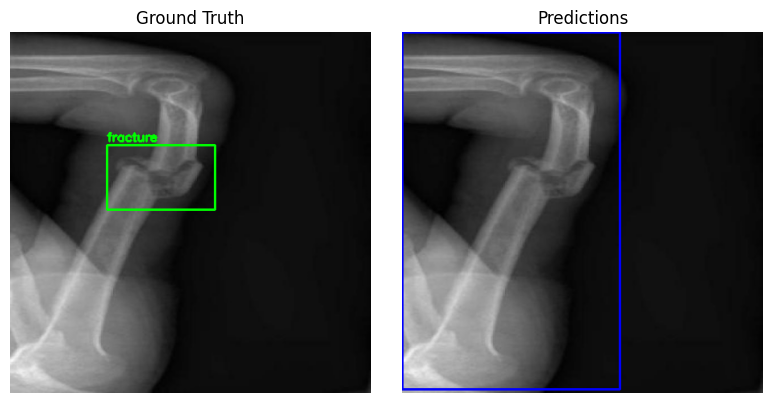

Displaying image: 2
Ground Truth: [[0.49023438 0.33789062 0.51953125 0.41210938]
 [0.41503906 0.19238281 0.44921875 0.32421875]], Predicted: [[0.17480469 0.         0.83203125 0.99902344]], IoU: [np.float64(0.0033116478498254848)]


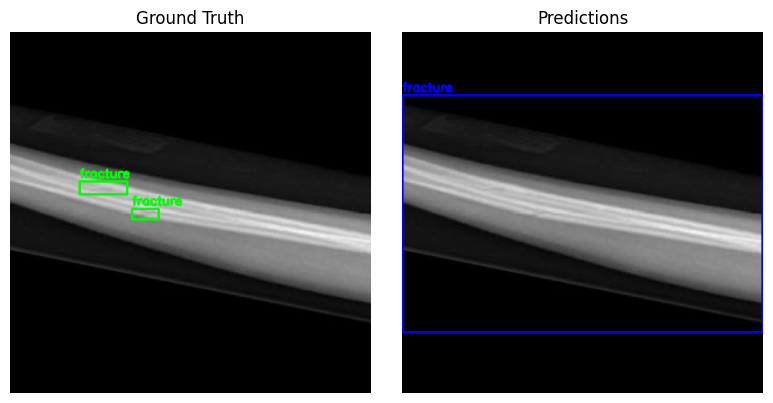

Displaying image: 3
Ground Truth: [[0.08007812 0.25683594 0.20898438 0.57714844]], Predicted: [[0.         0.09375    0.9921875  0.99902344]], IoU: [np.float64(0.045969981907601355)]


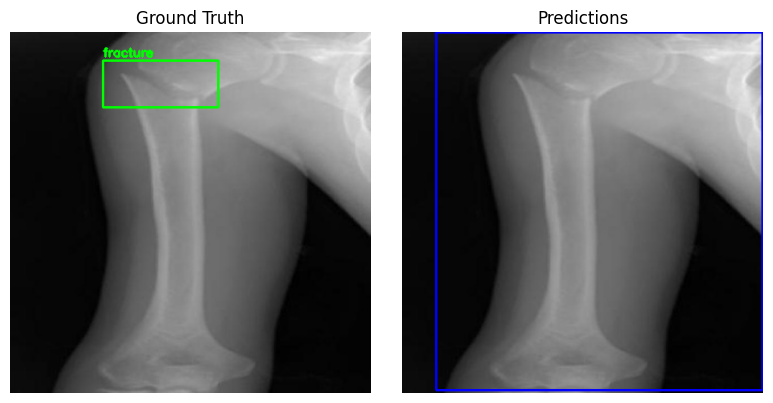

Displaying image: 4
Ground Truth: [[0.29394531 0.13476562 0.35644531 0.24023438]], Predicted: [[0.         0.         0.99023438 0.8046875 ]], IoU: [np.float64(0.008272534038030677)]


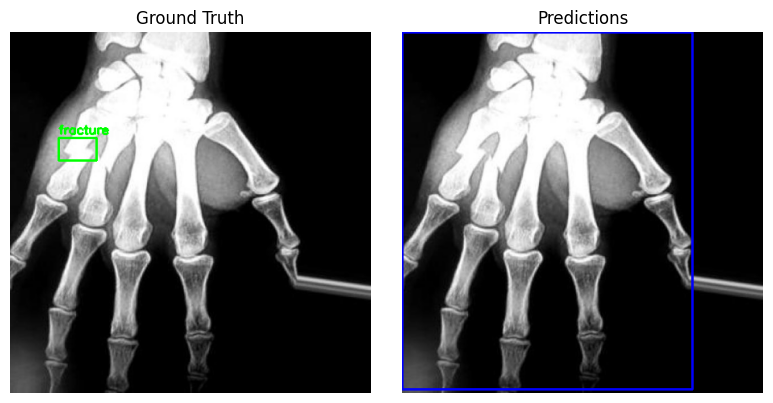

Displaying image: 5
Ground Truth: [[0.68847656 0.10351562 0.828125   0.38964844]], Predicted: [[0.         0.         0.99414062 0.99902344]], IoU: [np.float64(0.04023279886769335)]


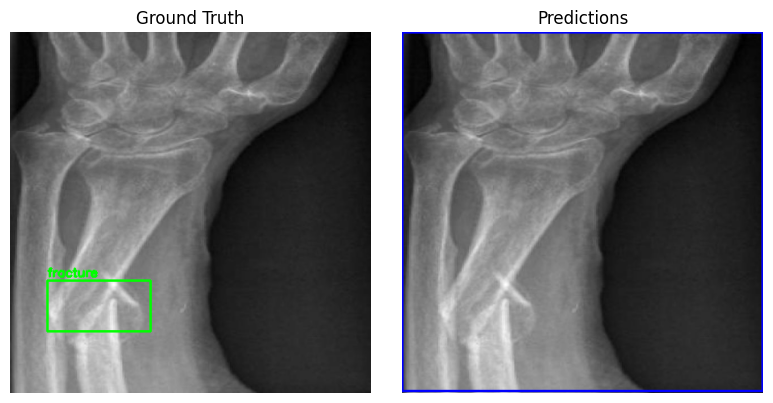

Displaying image: 6
Ground Truth: [[0.375      0.51757812 0.73242188 0.6953125 ]], Predicted: [[0.         0.         0.99902344 0.99414062]], IoU: [np.float64(0.06396303487373897)]


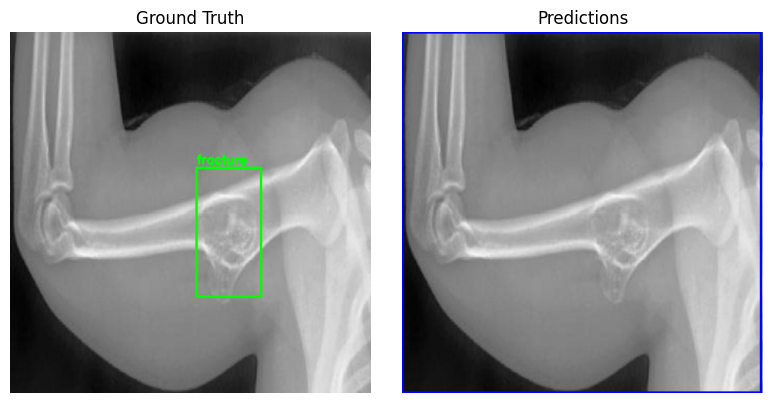

Displaying image: 7
Ground Truth: [[0.47265625 0.45117188 0.65820312 0.7109375 ]], Predicted: [[0.         0.         0.9921875  0.99902344]], IoU: [np.float64(0.048625703312012686)]


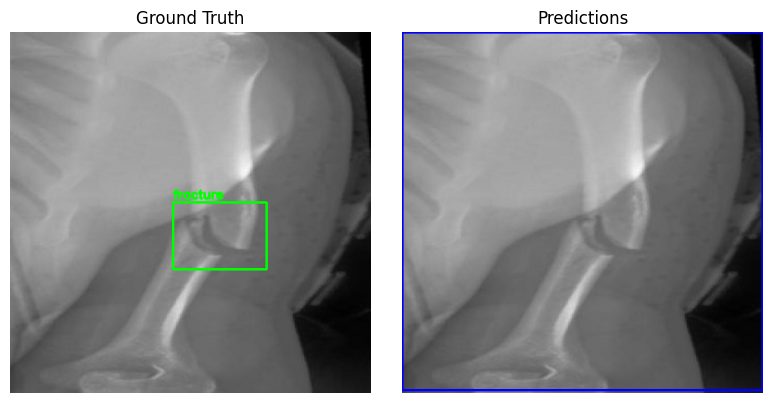

Displaying image: 8
Ground Truth: [[0.38574219 0.18554688 0.48535156 0.36523438]], Predicted: [[0.17480469 0.         0.82226562 0.99511719]], IoU: [np.float64(0.027779874688608742)]


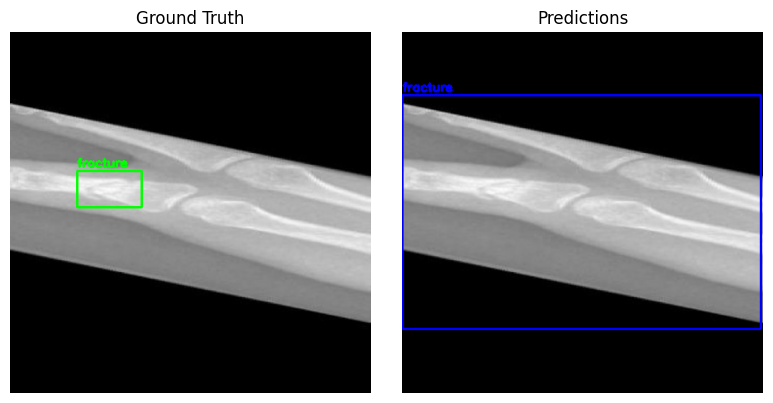

Displaying image: 9
Ground Truth: [[0.46289062 0.1640625  0.65039062 0.34667969]], Predicted: [[0.         0.         0.99902344 0.99511719]], IoU: [np.float64(0.03444236917914464)]


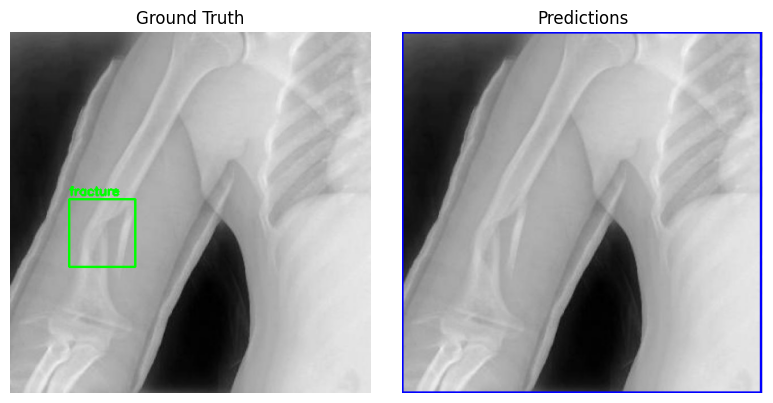

Displaying image: 10
Ground Truth: [[0.54882812 0.26953125 0.66113281 0.5234375 ]], Predicted: [[0.07714844 0.         0.99902344 0.99902344]], IoU: [np.float64(0.03096161174345975)]


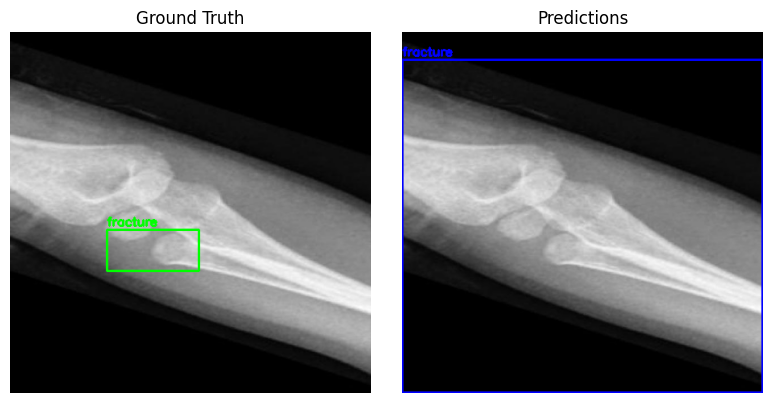

Displaying image: 11
Ground Truth: [[0.42773438 0.63085938 0.53125    0.67089844]], Predicted: [[0.         0.13867188 0.88476562 0.99902344]], IoU: [np.float64(0.005444846188732952)]


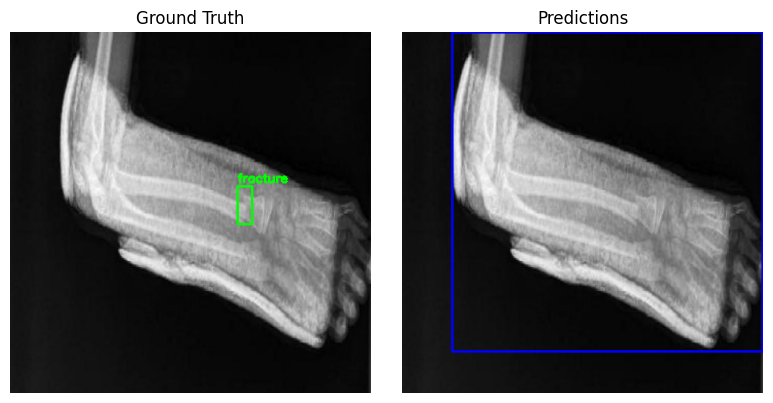

Displaying image: 12
Ground Truth: [[0.33691406 0.10742188 0.41699219 0.38476562]
 [0.51660156 0.03125    0.62792969 0.25097656]], Predicted: [[0.         0.         0.97851562 0.88183594]], IoU: [np.float64(0.025738114026653228)]


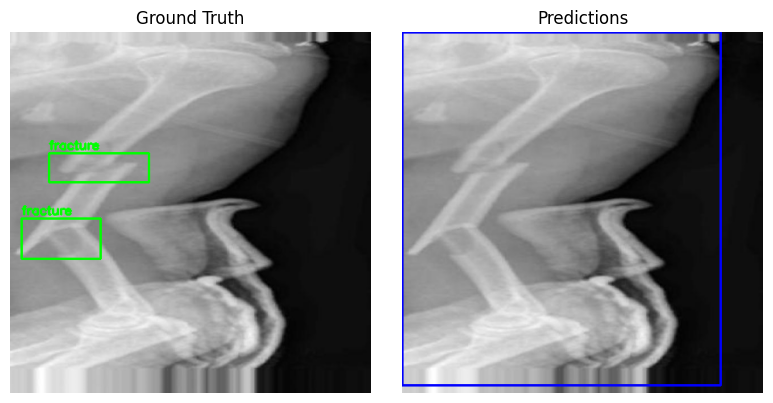

Displaying image: 13
Ground Truth: [[0.50976562 0.08691406 0.578125   0.20898438]], Predicted: [[0.         0.03417969 0.99023438 0.80078125]], IoU: [np.float64(0.010992600409552885)]


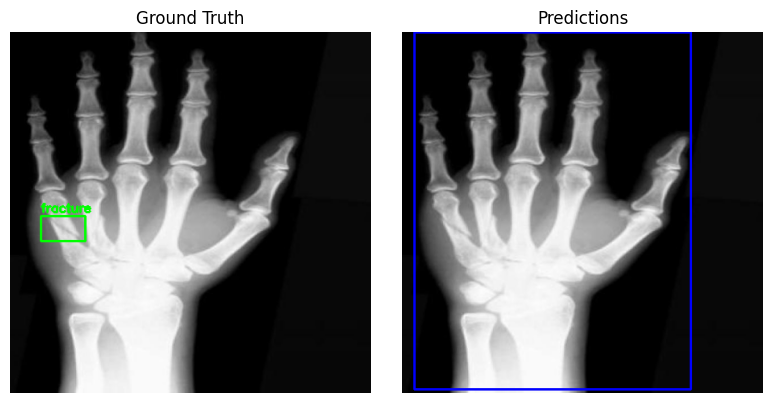

Displaying image: 14
Ground Truth: [[0.63183594 0.171875   0.74414062 0.34082031]], Predicted: [[0.         0.         0.99023438 0.99902344]], IoU: [np.float64(0.019179194117159376)]


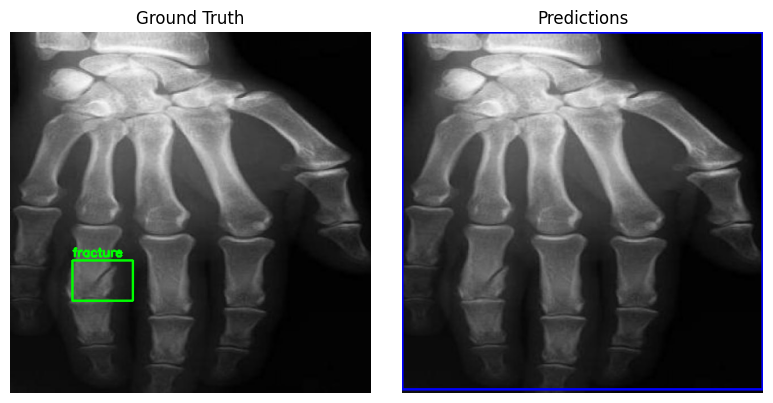

Displaying image: 15
Ground Truth: [[0.44628906 0.25683594 0.54980469 0.52539062]], Predicted: [[0.         0.         0.99414062 0.99902344]], IoU: [np.float64(0.027990789445887995)]


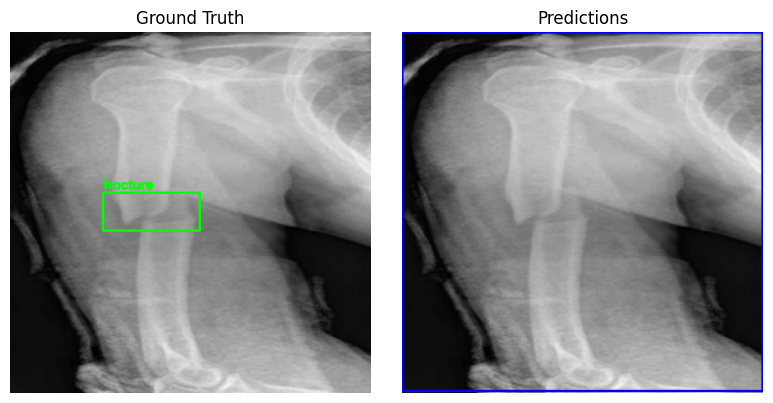

Displaying image: 16
Ground Truth: [[0.53808594 0.43554688 0.72363281 0.77539062]], Predicted: [[0.         0.         0.99023438 0.99902344]], IoU: [np.float64(0.06374105629688756)]


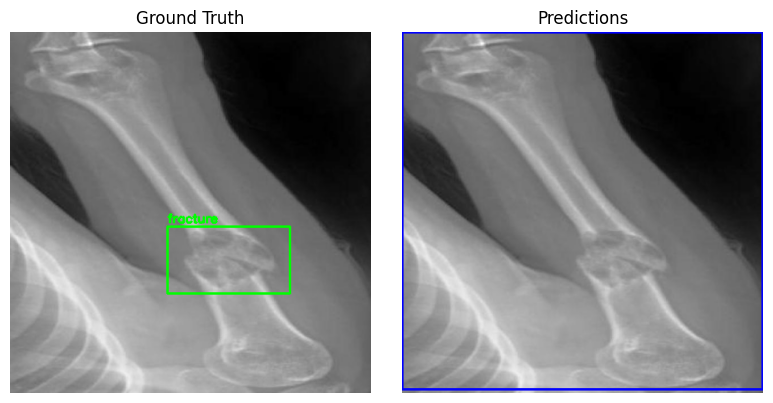

In [44]:
dataset_location = dataset.location
annotation_file = os.path.join(dataset_location, "dataset/_annotations.test.jsonl")
image_dir = os.path.join(dataset_location, "dataset")
target_size = (448, 448)
Prompt = 'detect fracture \n'

results = run_pipeline(annotation_file, image_dir, target_size, Prompt, display_limit=16, file_limit=16)

In [45]:
metrics = evaluate_model(results)
print(f"Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Performance Metrics:
IoU: 0.0323
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Label Accuracy: 0.0000


In [52]:
project = rf.workspace("deteksiparkir").project("car-detection-uzcmc")
version = project.version(1)
dataset = version.download("paligemma")
print("Dataset downloaded at:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded at: /home/gopi/Documents/ZSL/Gemma/main/car-detection-1


Displaying image: 1
Ground Truth: [[0.30957031 0.07617188 0.91894531 0.93554688]], Predicted: [[0.31347656 0.05761719 0.92089844 0.92578125]], IoU: [np.float64(0.9586299802018206)]


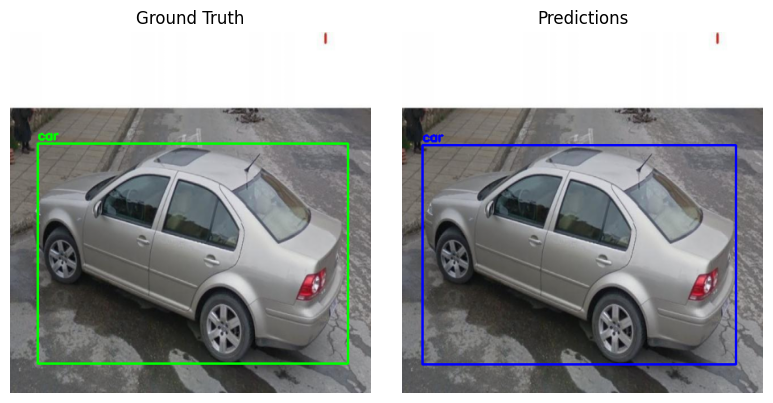

Displaying image: 2
Ground Truth: [[0.21191406 0.26171875 0.80078125 0.796875  ]], Predicted: [[0.         0.26757812 0.79101562 0.79296875]], IoU: [np.float64(0.7134193519533084)]


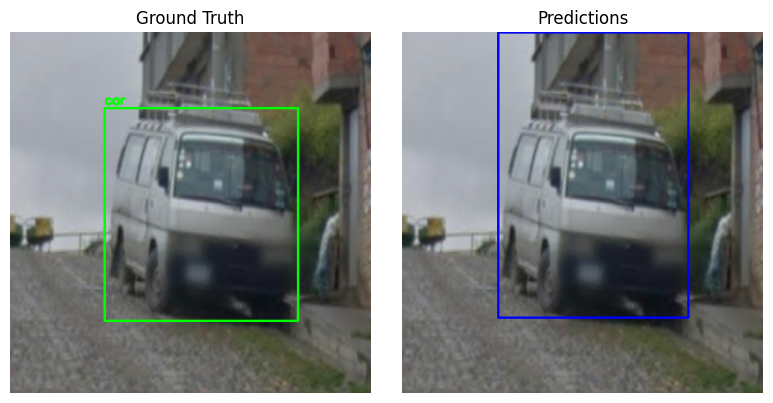

Displaying image: 3
Ground Truth: [[0.04003906 0.20117188 0.99804688 0.99902344]], Predicted: [[0.         0.21679688 0.99609375 0.99707031]], IoU: [np.float64(0.9376495380204163)]


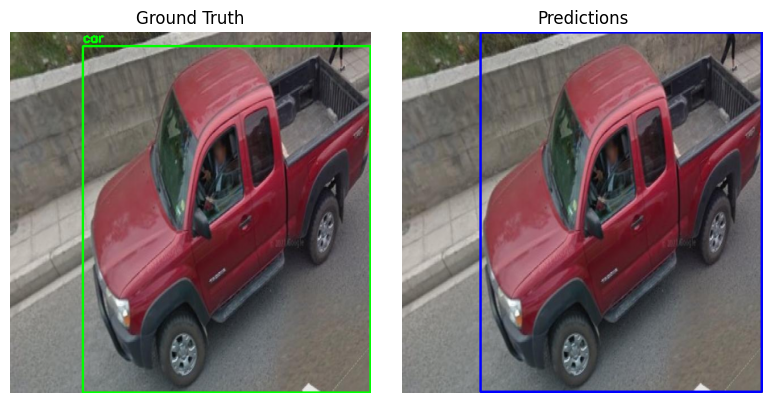

Displaying image: 4
Ground Truth: [[0.03125    0.046875   0.97753906 0.94335938]], Predicted: [[0.         0.05273438 0.96191406 0.93066406]], IoU: [np.float64(0.9329605470919407)]


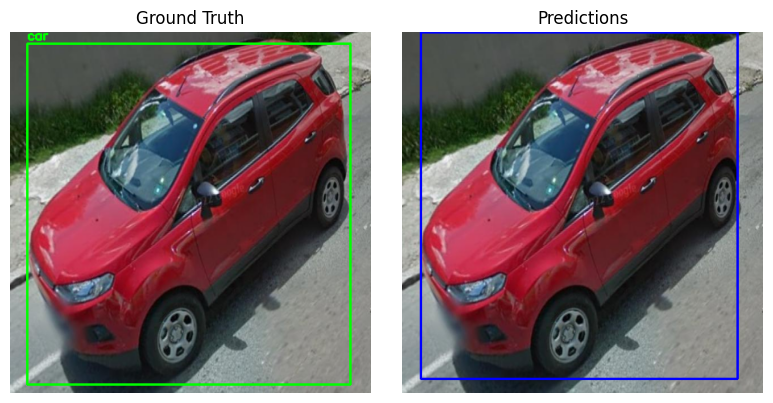

Displaying image: 5
Ground Truth: [[0.09082031 0.20410156 0.94238281 0.91015625]], Predicted: [[0.09667969 0.19335938 0.91601562 0.90625   ]], IoU: [np.float64(0.943028209196714)]


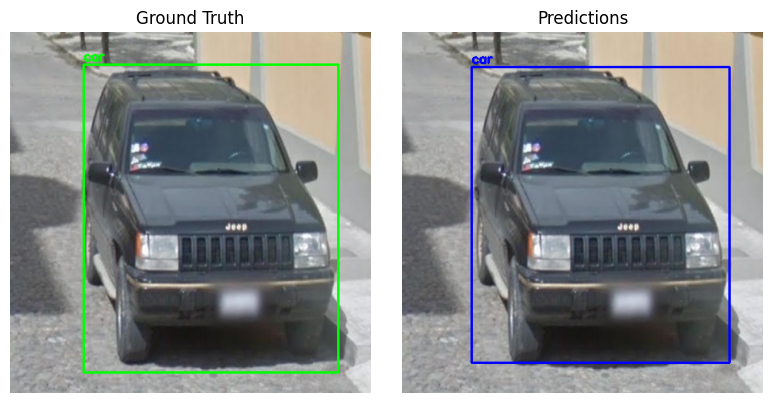

Displaying image: 6
Ground Truth: [[0.21875    0.17578125 0.82519531 0.87109375]], Predicted: [[0.2109375  0.17773438 0.82617188 0.87304688]], IoU: [np.float64(0.9802313017727801)]


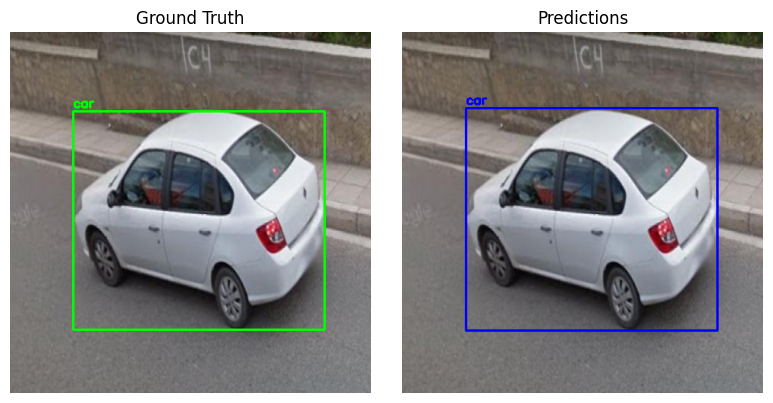

Displaying image: 7
Ground Truth: [[0.10449219 0.12890625 0.96972656 0.99316406]], Predicted: [[0.         0.11035156 0.96191406 0.99609375]], IoU: [np.float64(0.8629112412893195)]


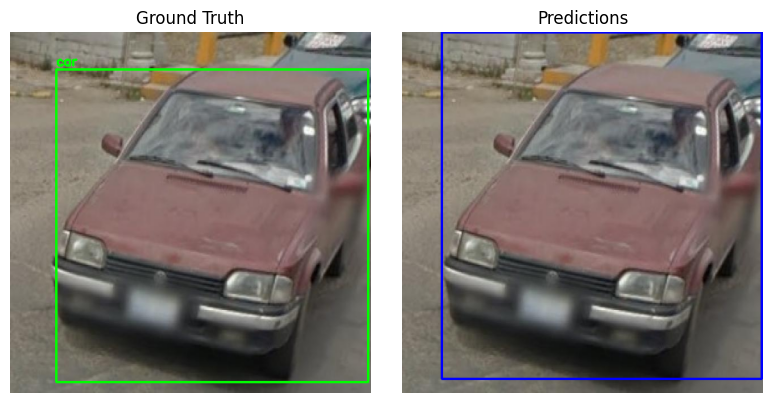

Displaying image: 8
Ground Truth: [[0.25       0.19042969 0.92089844 0.97460938]], Predicted: [[0.18457031 0.18457031 0.89941406 0.96191406]], IoU: [np.float64(0.8626677591985327)]


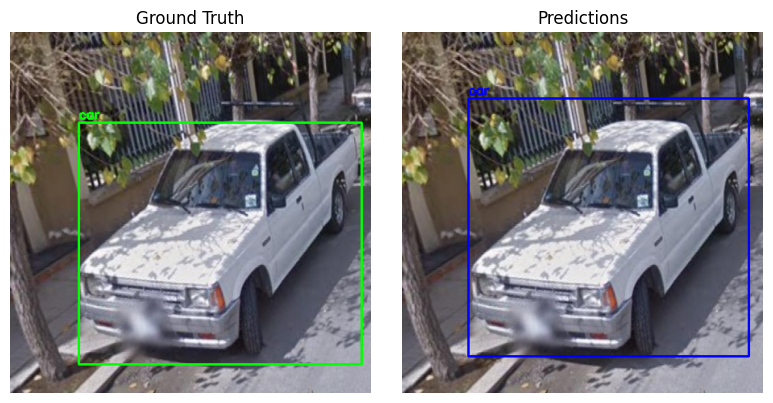

Displaying image: 9
Ground Truth: [[0.31835938 0.27441406 0.67480469 0.66503906]], Predicted: [[0.29296875 0.25       0.70117188 0.65722656]], IoU: [np.float64(0.8073307528240777)]


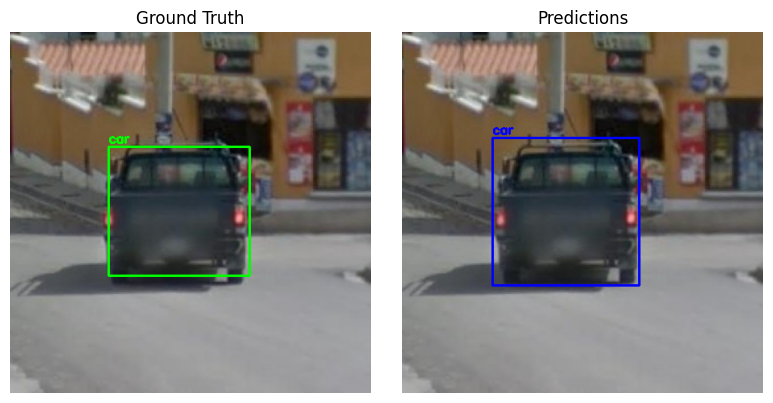

Displaying image: 10
Ground Truth: [[0.24609375 0.23535156 0.76855469 0.921875  ]], Predicted: [[0.22070312 0.22851562 0.71191406 0.91113281]], IoU: [np.float64(0.8301535644764573)]


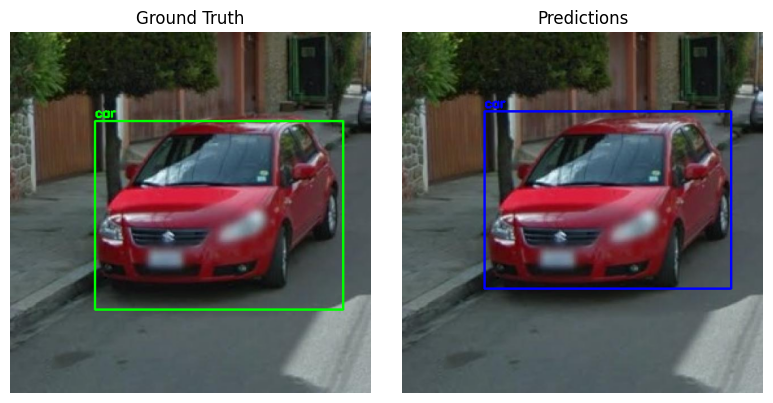

Displaying image: 11
Ground Truth: [[0.48046875 0.41796875 0.54980469 0.58105469]], Predicted: [[0.4765625  0.41796875 0.54589844 0.578125  ]], IoU: [np.float64(0.8781267481818908)]


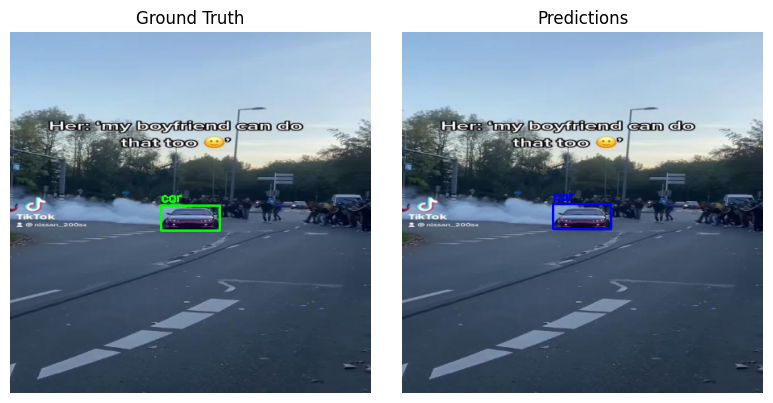

Displaying image: 12
Ground Truth: [[0.01171875 0.11035156 0.75097656 0.78222656]], Predicted: [[0.         0.13574219 0.74121094 0.75878906]], IoU: [np.float64(0.9018188286228978)]


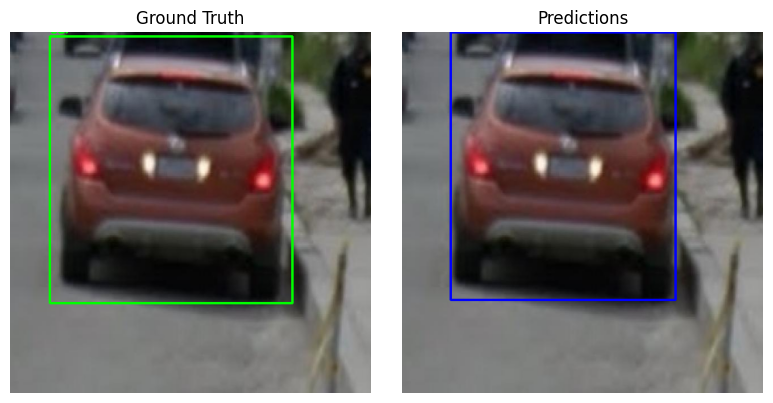

Displaying image: 13
Ground Truth: [[0.11035156 0.30761719 0.95703125 0.99902344]], Predicted: [[0.         0.27539062 0.94238281 0.99707031]], IoU: [np.float64(0.8291467884470384)]


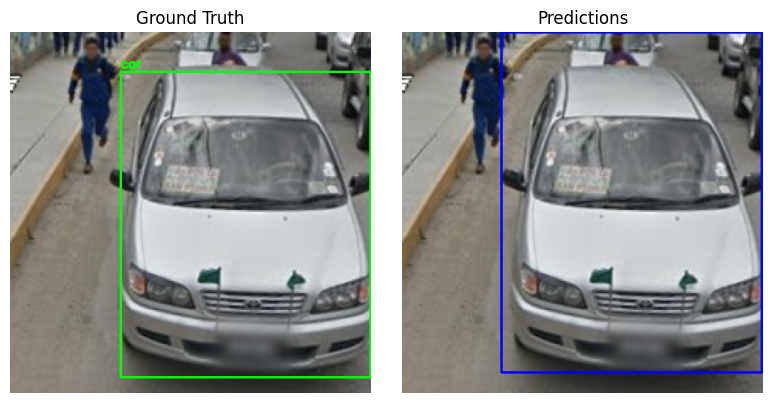

Displaying image: 14
Ground Truth: [[0.51074219 0.31347656 0.5703125  0.51855469]], Predicted: [[0.51660156 0.30175781 0.56738281 0.52246094]], IoU: [np.float64(0.8004691394223721)]


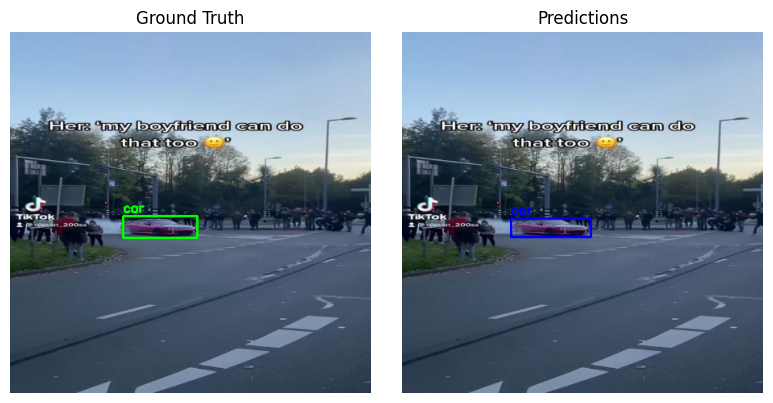

Displaying image: 15
Ground Truth: [[0.39160156 0.45996094 0.84765625 0.78808594]], Predicted: [[0.38378906 0.45703125 0.83691406 0.79003906]], IoU: [np.float64(0.9462450592885375)]


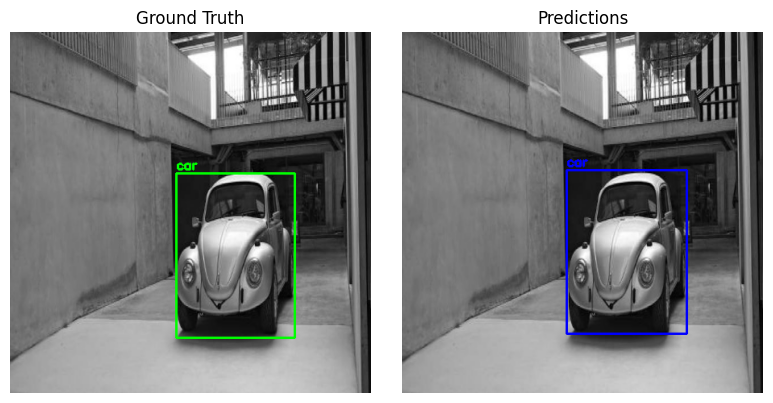

Displaying image: 16
Ground Truth: [[0.16699219 0.03125    0.75390625 0.9296875 ]], Predicted: [[0.140625   0.04101562 0.74609375 0.91601562]], IoU: [np.float64(0.9206670455648124)]


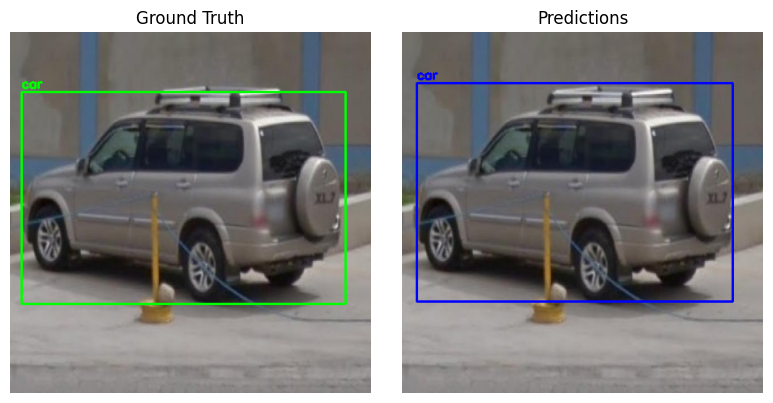

In [55]:
dataset_location = dataset.location
annotation_file = os.path.join(dataset_location, "dataset/_annotations.test.jsonl")
image_dir = os.path.join(dataset_location, "dataset")
target_size = (448, 448)
Prompt = 'detect car\n'

results = run_pipeline(annotation_file, image_dir, target_size, Prompt, display_limit=16, file_limit=16)

In [56]:
metrics = evaluate_model(results)
print(f"Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Performance Metrics:
IoU: 0.8816
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Label Accuracy: 1.0000


In [49]:
project = rf.workspace("objdet-odjxg").project("screw-7iwvy")
version = project.version(1)
dataset = version.download("paligemma")
print("Dataset downloaded at:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded at: /home/gopi/Documents/ZSL/Gemma/main/screw-1


Displaying image: 1
Ground Truth: [[0.80078125 0.16503906 0.85839844 0.22265625]], Predicted: [[0.140625   0.16113281 0.85546875 0.83203125]], IoU: [np.float64(0.006567791977513661)]


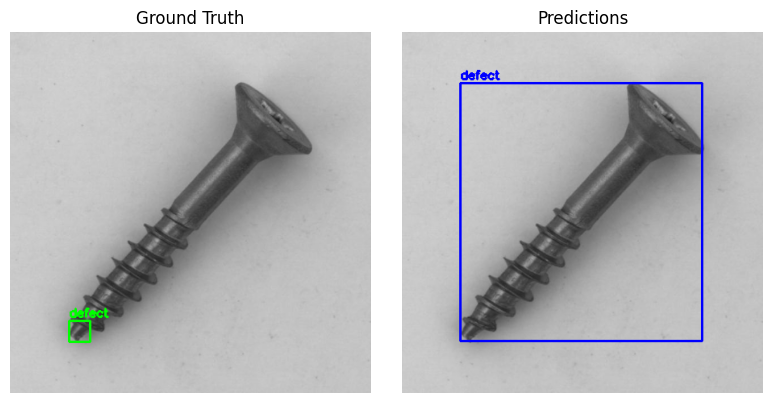

Displaying image: 2
Ground Truth: [[0.10058594 0.23242188 0.14257812 0.27246094]], Predicted: [[0.09667969 0.22265625 0.89257812 0.77441406]], IoU: [np.float64(0.0038286551930072207)]


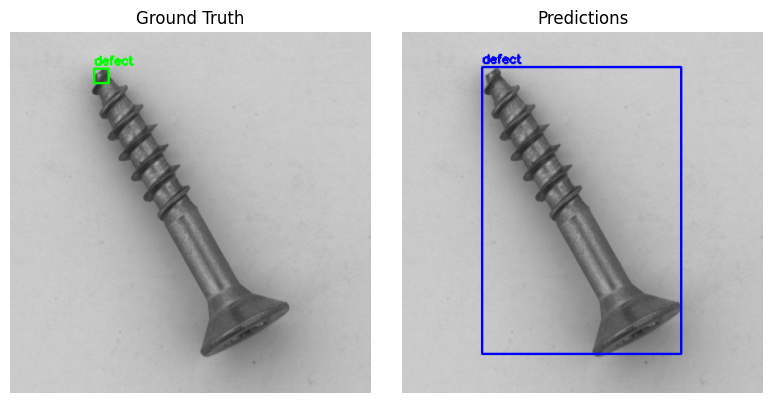

Displaying image: 3
Ground Truth: [[0.83203125 0.38671875 0.93359375 0.453125  ]], Predicted: [[0.0625     0.35449219 0.93164062 0.64453125]], IoU: [np.float64(0.026226433643644173)]


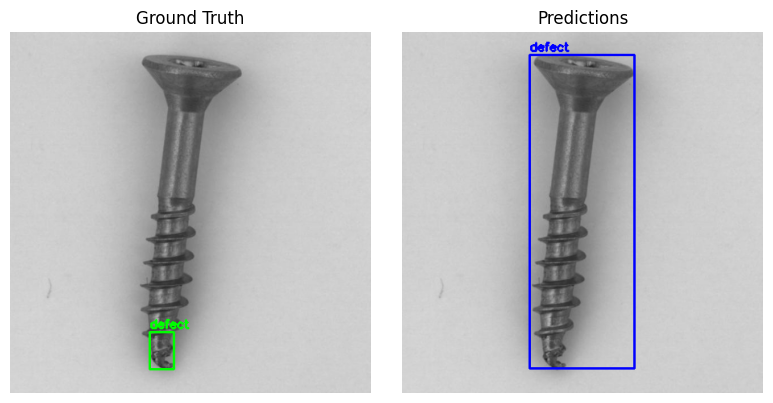

Displaying image: 4
Ground Truth: [[0.86425781 0.43261719 0.92480469 0.49902344]], Predicted: [[0.07226562 0.35449219 0.92089844 0.63671875]], IoU: [np.float64(0.01568733518155386)]


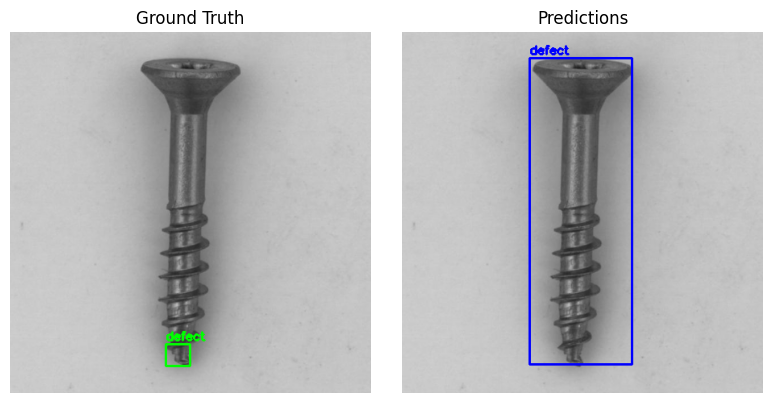

Displaying image: 5
Ground Truth: [[0.765625   0.34765625 0.93261719 0.45214844]], Predicted: [[0.06933594 0.33886719 0.93261719 0.65722656]], IoU: [np.float64(0.06349068650584348)]


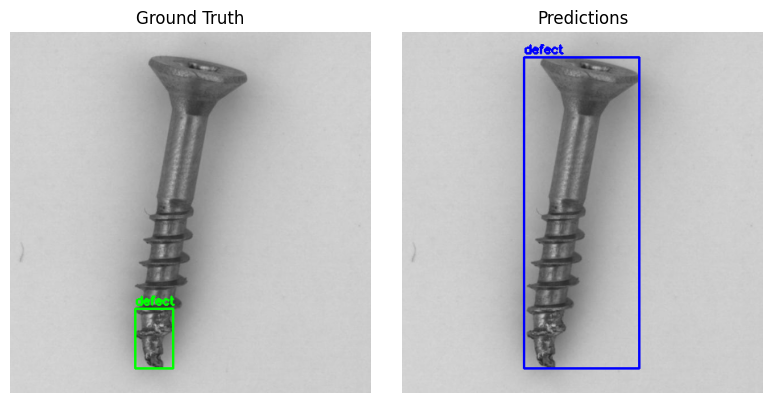

Displaying image: 6
Ground Truth: [[0.23046875 0.8515625  0.28125    0.92578125]], Predicted: [[0.22753906 0.10449219 0.77050781 0.89257812]], IoU: [np.float64(0.004848377214403054)]


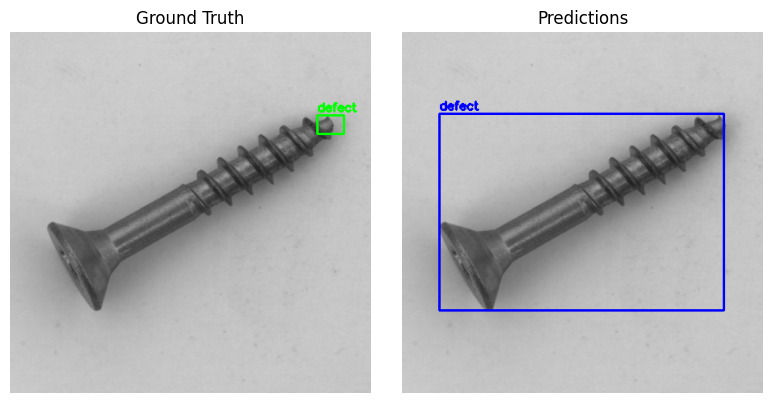

Displaying image: 7
Ground Truth: [[0.28320312 0.07617188 0.35058594 0.14257812]], Predicted: [[0.2734375  0.07714844 0.73046875 0.921875  ]], IoU: [np.float64(0.011417944177293035)]


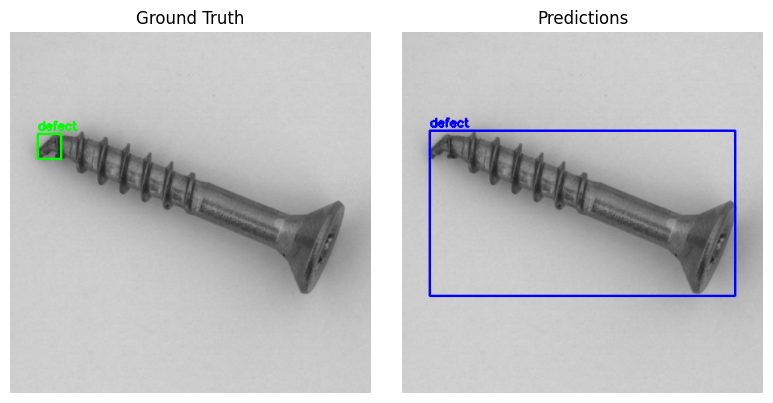

Displaying image: 8
Ground Truth: [[0.73242188 0.77050781 0.87011719 0.83398438]], Predicted: [[0.12988281 0.16210938 0.87304688 0.83203125]], IoU: [np.float64(0.017006555267954235)]


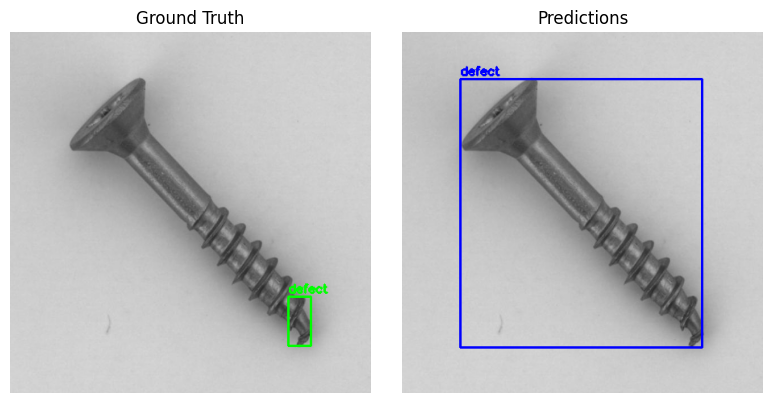

Displaying image: 9
Ground Truth: [[0.20410156 0.82714844 0.25878906 0.88476562]], Predicted: [[0.20117188 0.11523438 0.79492188 0.88183594]], IoU: [np.float64(0.006568254553375446)]


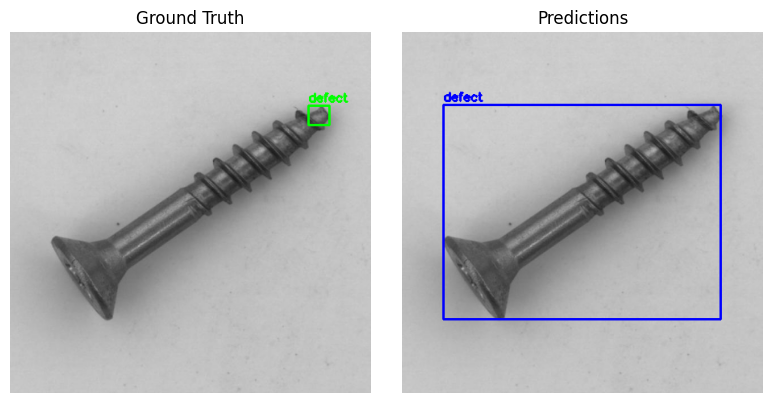

Displaying image: 10
Ground Truth: [[0.46679688 0.07421875 0.53613281 0.12695312]], Predicted: [[0.36035156 0.07714844 0.63671875 0.92871094]], IoU: [np.float64(0.0146605719283045)]


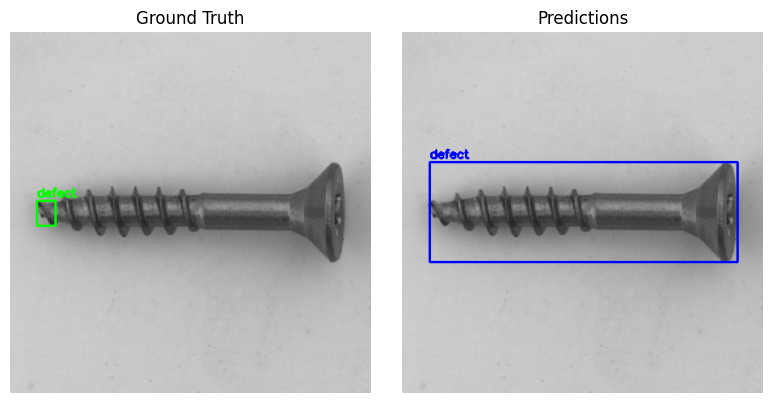

Displaying image: 11
Ground Truth: [[0.06738281 0.36816406 0.14941406 0.44726562]], Predicted: [[0.06347656 0.35058594 0.92871094 0.63671875]], IoU: [np.float64(0.02620975508285888)]


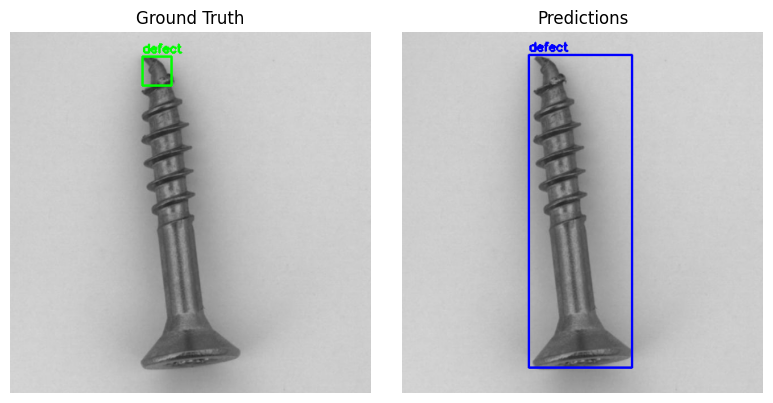

Displaying image: 12
Ground Truth: [[0.09179688 0.7265625  0.1796875  0.78417969]], Predicted: [[0.08984375 0.20703125 0.90625    0.78710938]], IoU: [np.float64(0.010693054951428157)]


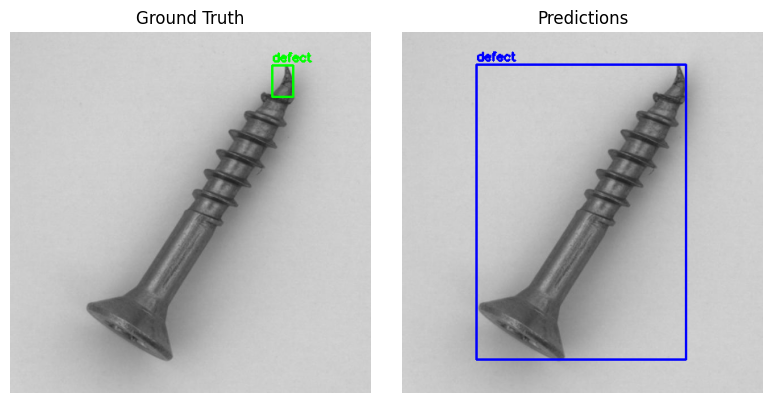

Displaying image: 13
Ground Truth: [[0.85839844 0.40820312 0.92675781 0.4609375 ]], Predicted: [[0.07226562 0.35253906 0.92480469 0.640625  ]], IoU: [np.float64(0.014252279316728962)]


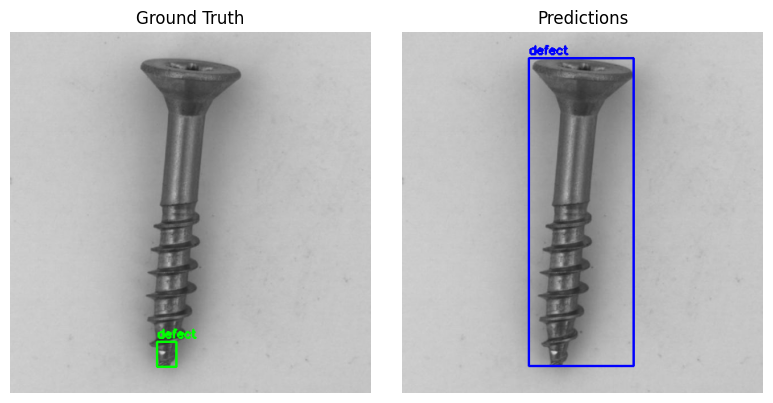

Displaying image: 14
Ground Truth: [[0.75585938 0.13867188 0.84570312 0.19140625]], Predicted: [[0.15136719 0.1328125  0.84375    0.86328125]], IoU: [np.float64(0.009162204961918408)]


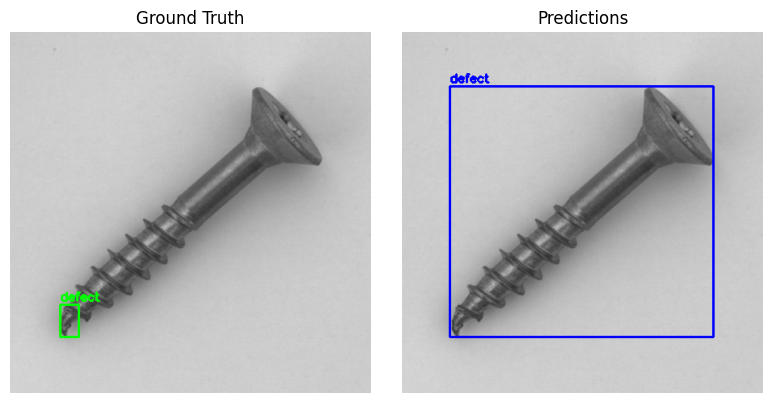

Displaying image: 15
Ground Truth: [[0.51367188 0.87207031 0.5703125  0.92285156]], Predicted: [], IoU: []


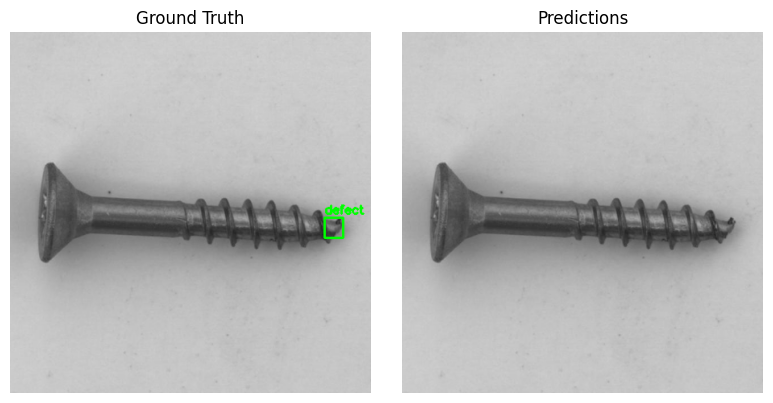

Displaying image: 16
Ground Truth: [[0.69628906 0.07910156 0.74707031 0.18261719]], Predicted: [], IoU: []


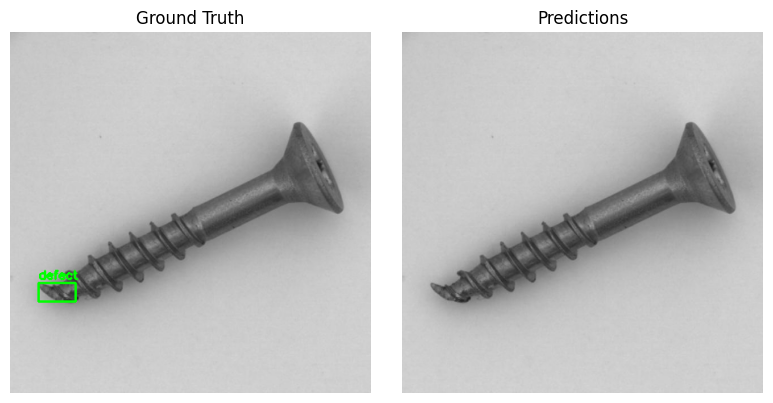

In [50]:
dataset_location = dataset.location
annotation_file = os.path.join(dataset_location, "dataset/_annotations.test.jsonl")
image_dir = os.path.join(dataset_location, "dataset")
target_size = (448, 448)
Prompt = 'detect defect\n'

results = run_pipeline(annotation_file, image_dir, target_size, Prompt, display_limit=16, file_limit=16)

In [51]:
metrics = evaluate_model(results)
print(f"Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Performance Metrics:
IoU: 0.0144
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Label Accuracy: 0.0000
